<a href="https://colab.research.google.com/github/succSeeded/dl-2025/blob/main/hws/week04_finetuning/seminar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch
import torch
import torchvision
from torchvision import transforms
# I, sadly, have only one GPU, so I had to append :0 to cuda to avoid errors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# Ensure that output below says `device=device(type='cuda')` - you will need CUDA for faster model runs
# If in Colab, we recommend that you go to Runtime -> Change Runtime Type -> GPU

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='2.7.1+cu126', torchvision.__version__='0.22.1+cu126', device=device(type='cuda', index=0), torch.get_num_threads()=8


In [2]:
# loading Imagenet class labels for interpreting classification results
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


In [3]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);        # set the model to evaluation mode

In [4]:
# Create model clone with altered last layer
embedding_model = deepcopy(model)  # start with a clone of the original model
embedding_model.fc = torch.nn.Identity() # instead of classifier head - do nothing
embedding_model = embedding_model.to(device)  # move to CUDA if available

In [5]:
# download the dataset
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O data.zip -q --show-progress
!unzip -qn data.zip -d data/
!rm data.zip
!ls data/dogs_vs_cats_1000 | wc -l  # should be 2000 images extracted

data.zip            100%[===================>]  44.25M  10.7MB/s    in 4.1s    
2000


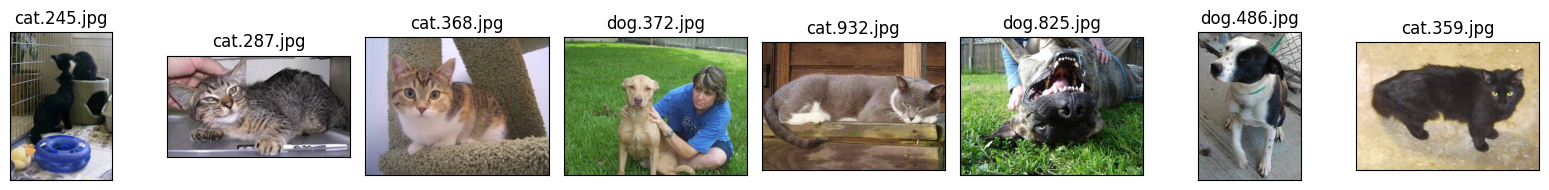

In [6]:
# Sample pets images
import random
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

dataset_path = os.path.join("data", "dogs_vs_cats_1000")

fnames = [fn for fn in os.listdir(dataset_path)]
for ax, fname in zip(axs.ravel(), random.choices(fnames, k=8)):
    img_ = Image.open(os.path.join(dataset_path, fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [7]:
# Here we generate image embeddings using the activations before the last layer
# use batches to accelerate the process

X_ = []  # storage for batches embeddings
Y_ = []  # storage for batches labels

filenames = [fname for fname in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, fname))]
batch_size = 64
x_batch_list = []  # to accumulate batch components

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        img = Image.open(os.path.join(dataset_path, fname))
        img_torch = transforms.ToTensor()(img.resize((224, 224)))
        x_batch_list.append(img_torch)
        Y_.append(1 if fname.startswith("cat") else 0)

        if len(x_batch_list) == batch_size or i >= len(filenames) - 1:
            x_batch = torch.stack(x_batch_list) # [64, 3, H, W]
            # use your embedding model to produce embeddings vectors, save results on CPU
            embeddings = embedding_model(x_batch.to(device)).cpu()

            assert isinstance(embeddings,  torch.Tensor) and embeddings.device.type == "cpu"
            assert embeddings.ndim == 2 and embeddings.shape[1] == 512
            X_.append(embeddings)
            x_batch_list = []

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array.
Y = np.array(Y_[:len(X)])  # convert labels into np array; crop if we ended prematurely

print(X.shape, Y.shape, np.mean(Y))

assert X.ndim == 2 and X.shape[1] == 512
assert X.shape[0] == len(filenames)
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.49 <= np.mean(Y) <= 0.51

(2000, 512) (2000,) 0.5


### Using model embeddings as classifier features

Train sklearn model, evaluate validation accuracy (should be >90%)

In [9]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

__Task 1 (2 points): train the model and evaluate its accuracy on a hold-out set.__
- write the code for cats/dogs classification using the embeddings created above. Use any classification tools that you learned. Reach at least 95% accuracy. __(1 point)__.  Try few different tools if accuracy is not high enough. <br>
(You may choose any classifier algorithm as long as it gets above 95% accuracy. To get the max grade here, you need to tune main hyperparameters of your chosen algorithm (e.g. k for KNN, tree depth, logreg C) depending on how many data points you have. )
- try this excercise with much smaller training set. Find the lowest train set size at which you can still predict cat/dog class with 95% accuracy __(1 point)__ <br>
(note: exact threshold may depend on algorightm choice and train/test split. Show your effort in  experimenting with low train set sizes.)

In [10]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

np.random.seed(120)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# let us create a "random" subsample for testing purposes
subset_size = 200
subset_ids = np.random.choice(
    np.arange(X_train.shape[0]), size=subset_size, replace=False
)

X_trainSub = X_train[subset_ids]
Y_trainSub = Y_train[subset_ids]

# # AdaBoost achieves >95% accuracy with at least 170 data entries
# pipe = Pipeline(
#     [
#         ("transform", StandardScaler()),
#         ("model", AdaBoostClassifier(n_estimators=100)),
#     ]
# ).fit(X_trainSub, Y_trainSub)

# # LogReg **can** achieve >95% accuracy score with 72 data entries, but this is unreliable since it is the case only for certain
# # random seeds. It can reliably get to 95% with 150 entries
# pipe = Pipeline(
#     [
#         ("transform", StandardScaler()),
#         (
#             "model",
#             LogisticRegression(dual=True, intercept_scaling=2.0, solver="liblinear"),
#         ),
#     ]
# ).fit(X_trainSub, Y_trainSub)

# KNN has to have at least 200 entries to somewhat reliably breach 95% accuracy threshold 
pipe = Pipeline(
    [
        ("transform", StandardScaler()),
        (
            "model",
            KNeighborsClassifier(n_neighbors=7, weights="distance"),
        ),
    ]
).fit(X_trainSub, Y_trainSub)

Y_pred = pipe.predict(X_test)
acc_score = (Y_pred == Y_test).sum() / Y_pred.shape[0]

print(f"accuracy = {acc_score:.1%}")
print(f"Is it more than or equal to 95%? {acc_score >= 0.95}")

accuracy = 95.5%
Is it more than or equal to 95%? True
CPU times: user 1.04 s, sys: 8.6 ms, total: 1.05 s
Wall time: 81.8 ms


## Torchvision Datasets
- Built-in datasets https://pytorch.org/vision/stable/datasets.html#built-in-datasets

- Datasets and Dataloaders at `torch.utils.data`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Torchvision classes for custom datasets  https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets

# Problem 2: Clasification of cat/dog breeds using Oxford pets dataset

The next problem is to classify specific cat / dog breeds from popular Oxford pets dataset. It is conveniently provided by Pytorch so loading and using it is very easy.

Dataset home page: https://www.robots.ox.ac.uk/~vgg/data/pets/

Available from Pytorch: https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet



In [11]:
# Loading train and test subsets of the dataset

test_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation([-30, 30]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=True,
    transform=test_transform,
)
test_dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    split="test",
    target_types="category",
    download=True,
    transform=test_transform,
)

print("dataset sizes:", len(train_dataset), len(test_dataset))

print(train_dataset.classes)

dataset sizes: 3680 3669
['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [12]:
# create dataloaders to repack the datasets' data into batches
# read more

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)
print("dataloader sizes:", len(train_dataloader), len(test_dataloader))

dataloader sizes: 58 58


In [13]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(
    weights=ResNet18_Weights.DEFAULT
)  # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);  # set the model to evaluation mode

Remember that Imagenet includes quite a few cat and dog breeds among its classes.

Let's try to predict breeds with Imagenet-pretrained model without finetuning first

In [14]:
# Predicting breeds with Imagenet-pretrained model
Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)  # tensor with class probabilities
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 1000]))

In [15]:
# Output top 3 predictions for each class using pretrained CNN (no finetuning)
# Expect to see high accuracy (70-80%) in some classes, much lower overall, mismatch in label spaces.

# Since there is a mismatch between the number of model outputs and the number of classes,
# getting actual accuracy score requires either some sort of map of model outputs to class labels
# or just changes to the model itself (which is a part of the next task, hence I decided to not
# change this part of code)

results_list = {}

for i, cl in enumerate(test_dataset.classes):
    class_stats = {"true_label": cl}
    probs1 = Y_probs[np.where(Y_true == i)].mean(axis=0).numpy()
    top_ix = probs1.argsort()[-1:][::-1]
    # class_stats
    for j, l in enumerate(top_ix):
        class_stats = {f"pred_1": imagenet_labels[l], f"prob_{1}": probs1.ravel()[l]}
    results_list[cl] = class_stats

df = pd.DataFrame(results_list).T.sort_values("prob_1", ascending=False)
float_cols = ["prob_1"]
df.style.format("{:.2%}", subset=float_cols)

,pred_1,prob_1
Siamese,Siamese_cat,94.51%
Keeshond,keeshond,94.35%
Saint Bernard,Saint_Bernard,90.23%
Persian,Persian_cat,87.12%
Pomeranian,Pomeranian,85.34%
Pug,pug,84.19%
Samoyed,Samoyed,82.18%
Boxer,boxer,82.16%
Egyptian Mau,Egyptian_cat,82.02%
Leonberger,Leonberg,82.00%


### Finetuning CNN: classification layer only:

__Task 2: (3 points)__:<br>
Complete the code below and reach at least 85% accuracy by training only the classification layer:

In [16]:
import torch.nn as nn

ft_model = deepcopy(model).to(device)
ft_model.fc = nn.Linear(512, 37)
ft_model = ft_model.to(device)

# your task:
# 1) freeze all model parameters
# 2) replace model.fc with a new linear layer that has the appropriate number of outputs

params_to_train = []

for name, param in ft_model.named_parameters():
    if name.startswith("fc."):
        params_to_train.append(param)
        param.requires_grad = True
        print(name, param.shape)
    else:
        param.requires_grad = False

opt = torch.optim.Adam(params_to_train)

assert all(not p.requires_grad for p in ft_model.parameters() if p not in set(ft_model.fc.parameters()))
assert ft_model.fc.out_features == len(train_dataset.classes)
assert ft_model.fc.weight.device == device, f"ft_model.fc must be on {device}"
assert ft_model.fc.weight.requires_grad

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.001)

fc.weight torch.Size([37, 512])
fc.bias torch.Size([37])


In [17]:
import pathlib

def train(model, opt, train_dataset, test_dataset, num_epochs:int = 10, batch_size:int = 64, stop:int = 7, device:str = None) -> dict:
    """
    A function for training torch models that I kindly took from the professor (sorry) but now with torch dataloaders

    Args:
        model: torch model to train
        opt: optimizer for that model
        train_dataset: torch.Dataset used for training & validation
        num_epochs: total amount of full passes over training data (default: 100)
        batch_size: number of samples processed in one SGD iteration (default: 64)
        stop: number of iterations that loss can decrease for before the training proces stops (default: 7)
    """
    best_val_acc = 0.0
    best_epoch = 0
    history = defaultdict(list)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        
        train_losses = []
        pbar = tqdm(train_dataloader, leave=False)
        for x_batch, y_batch in pbar:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
    
            # calculate model predictions, calculate loss, make optimizer step
            logits = model(x_batch)
            loss = torch.nn.functional.cross_entropy(logits, y_batch).mean()
    
            train_losses.append(loss.item())
            pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # And a full pass over the validation data:
        model.train(False)     # disable dropout / use averages for batch_norm
        model.eval()
        val_losses = []
        val_cnt, val_correct = 0, 0
        pbar = tqdm(test_dataloader, leave=False)
        with torch.no_grad():  # do not store intermediate activations
            for x_batch, y_batch in pbar:
    
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                # get model predictions, measure loss, collect data for accuracy calc
                logits = model(x_batch)
                
                y_pred = logits.argmax(-1)
                loss = torch.nn.functional.cross_entropy(logits, y_batch).mean()
        
                val_losses.append(loss.item())
                val_cnt += y_batch.shape[0]
                val_correct += (y_batch == y_pred).sum().item()
                pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        accuracy = val_correct / val_cnt
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)
        print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

        if best_val_acc < accuracy:
            best_val_acc = accuracy
            best_epoch = epoch
            pathlib.Path("./models/").mkdir(exist_ok=True)
            torch.save(model.state_dict(), f"models/model_new_head.pt2")


        if epoch - best_epoch > stop:
            print(f"Model did not see any loss improvements for {stop} epochs, aborting...")
            model.load_state_dict(torch.load(f"models/model_new_head.pt2", weights_only=True))
            model.eval()
            break
    print(f"Best Accuracy = {max(history['accuracy']):.2%}")
    return history

In [18]:
# train the finetuning model in a standard training loop.

hist = train(ft_model, optimizer, train_dataset, test_dataset, device=device, num_epochs=15)
accuracy = max(hist['accuracy'])

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=2.21512  val_loss=1.21971  accuracy=77.05%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.90816  val_loss=0.75075  accuracy=84.68%  epoch_time=18.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.60519  val_loss=0.61520  accuracy=85.77%  epoch_time=18.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.46661  val_loss=0.53926  accuracy=86.51%  epoch_time=18.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.39854  val_loss=0.50112  accuracy=86.32%  epoch_time=18.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.33870  val_loss=0.49112  accuracy=86.13%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=0.29611  val_loss=0.44369  accuracy=87.74%  epoch_time=18.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=0.26272  val_loss=0.43635  accuracy=87.57%  epoch_time=18.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=0.24202  val_loss=0.42975  accuracy=87.22%  epoch_time=18.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 9: train_loss=0.22333  val_loss=0.42184  accuracy=87.57%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.10: train_loss=0.19786  val_loss=0.42574  accuracy=87.27%  epoch_time=18.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.11: train_loss=0.18535  val_loss=0.41449  accuracy=87.49%  epoch_time=18.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.12: train_loss=0.17366  val_loss=0.41453  accuracy=87.52%  epoch_time=18.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.13: train_loss=0.15998  val_loss=0.40903  accuracy=87.54%  epoch_time=18.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.14: train_loss=0.14618  val_loss=0.40138  accuracy=87.95%  epoch_time=18.5s
Best Accuracy = 87.95%


In [19]:
# This part of finetuning alone should deliver at least 85% accuracy.
assert accuracy > 0.85

In [20]:
# Predicting breeds with finetuned model

Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 37]))

In [21]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    y_predicted = Y_probs[class_preds].numpy().argmax(-1)
    acc1 = (y_predicted == i).mean()
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1

df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

,acc1
German Shorthaired,99.00%
Keeshond,98.99%
Leonberger,98.00%
Samoyed,98.00%
Shiba Inu,97.00%
Scottish Terrier,96.97%
Yorkshire Terrier,96.00%
Havanese,96.00%
Great Pyrenees,96.00%
Japanese Chin,96.00%


### Finetuning CNN: now unfreeze and train all layers:

__task 3 (5 points)__: Based on the previous task, continue finetuning the model run by training all of its layers. Obtain at least 90% accuracy (macro average, as defined in the code).
To reach 90%, you will need to experiment with network and/or training code, start from using improvements from the list below:

Scoring:
- reaching 90% accuracy - __3 points__
- testing out all 4 of these improvements - __2 points__:
    - Hyperparameters optimization
    - Image augmentation
    - Pretrained model selection
    - Early stopping training at epoch with best metric and / or loading the weights of best epoch. [read about `state_dict`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)
    
(you may not necessarily get spectacular results right away. Experiment and describe your actions and findings in a brief report in this notebook.)
- scoring above 90% -- __+1 BONUS point__ for every 1% improvement in accuracy above 90%

__Guidelines__: to improve quality of the finetuned model we can now train all of its layers.
- do this after initial training of classification layer
- set learning rate to much lower level to avoid explosion
- make all layers trainable using `requires_grad` param

In [22]:
# Continue training with all layers involved

for name, param in ft_model.named_parameters():
    params_to_train.append(param)
    param.requires_grad = True

assert all (p.requires_grad for p in ft_model.parameters())

optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.0001)  # reduce LR to avoid explosion

In [23]:
# train the finetuning model in a standard training loop.

hist_new = train(ft_model, optimizer, train_dataset, test_dataset, num_epochs=30, device=device)
accuracy_new = max(hist_new['accuracy'])

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=0.16767  val_loss=0.40403  accuracy=87.05%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.03040  val_loss=0.35457  accuracy=89.10%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.00858  val_loss=0.34130  accuracy=89.32%  epoch_time=19.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.00525  val_loss=0.34608  accuracy=89.32%  epoch_time=18.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.00380  val_loss=0.34415  accuracy=89.42%  epoch_time=18.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.00284  val_loss=0.34791  accuracy=89.62%  epoch_time=19.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=0.00239  val_loss=0.34606  accuracy=89.62%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=0.00191  val_loss=0.34822  accuracy=89.72%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=0.00164  val_loss=0.35072  accuracy=89.56%  epoch_time=19.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 9: train_loss=0.00140  val_loss=0.34596  accuracy=89.86%  epoch_time=19.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.10: train_loss=0.00117  val_loss=0.35188  accuracy=89.64%  epoch_time=19.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.11: train_loss=0.00110  val_loss=0.34946  accuracy=89.67%  epoch_time=19.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.12: train_loss=0.00101  val_loss=0.35028  accuracy=89.75%  epoch_time=19.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.13: train_loss=0.00083  val_loss=0.35259  accuracy=89.62%  epoch_time=19.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.14: train_loss=0.00078  val_loss=0.35199  accuracy=89.78%  epoch_time=18.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.15: train_loss=0.00070  val_loss=0.35521  accuracy=89.59%  epoch_time=18.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.16: train_loss=0.00062  val_loss=0.35446  accuracy=89.75%  epoch_time=19.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.17: train_loss=0.00057  val_loss=0.35647  accuracy=89.83%  epoch_time=18.9s
Model did not see any loss improvements for 7 epochs, aborting...
Best Accuracy = 89.86%


In [24]:
# Predicting breeds with finetuned model

Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)

Y_pred = Y_probs.argmax(-1)

correct = (Y_pred.numpy() == Y_true.numpy()).sum()
total = Y_true.shape[0]

  0%|          | 0/58 [00:00<?, ?it/s]

In [25]:
print(f"Overall Accuracy = {correct / total:.2%}")  # macro-averaged accuracy
assert correct / total >= 0.9

Overall Accuracy = 89.86%


AssertionError: 

In [ ]:
# Some experiements with other models

# STUDENT'S REPORT

Please write a short report describing the steps you took to improve quality. It should be at least a short paragraph with 3-5 sentences and, optionally, any relevant numbers/charts, but there's no upper limit.

Here's what i did:

First I augmented the dataset with **crops**, **rotations** and **random clips**. I then selected the base `ResNet-18` model and changed the output layer to have 37 classes instead of 1000 as per instructions. 

After separately training the new layer, I trained the whole model utilizing the following training process:
* training data is passed batch-by-batch to the model, loss is calculated and backpropagated;
* model is evaluated on the test set its performance accuracy is recorded;
* the process is stopped after either a specified amount of epochs pass without accuracy metric increases or the process reaches the maximum number of epochs.   

# Bonus task __(optional. 2 more points)__:

Notice that accuracy varies across breeds. Build confusion Propose improvements to the model finetuning process to improve minimal accuracy levels for all classes. Show the model runs.
Measure the improvement in terms of minimal accuracy and micro-averaged accuracy.

# EXTRA STUFF:


## Links:    
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
- [Activations Atlas](https://distill.pub/2019/activation-atlas/)
- more models from https://github.com/huggingface/pytorch-image-models
- Papers with code: benchmarks and model references. https://paperswithcode.com/sota/image-classification-on-imagenet